In [ ]:
def print_columns(df):
    for c in df.columns:
        uniques = df[c].unique()
        if len(uniques) < 10:
            print(c, uniques)
        else:
            print(c, 'count:', len(uniques))

## Ad-smart

Нулевая гипотеза: Нет существенной разницы между показателями успешности рекламы в обеих группах

Компания ожидает, что новая рекламная стратегия увеличит успешность рекламы с 45% до 50% (+5pp / +11%) <br>
BIO questionnaire

Необходимый препроцесс:
* удалить неотвеченные
* посмотреть на просто средние кол-ва успехов

Под вопросом:
* EDA (Exploratory Data Analysis) [какой-то отдельный EDA-ноутбук](https://www.kaggle.com/code/faridrizqis/a-b-testing-eda)

In [ ]:
# https://www.kaggle.com/datasets/osuolaleemmanuel/ad-ab-testing
data = pd.read_csv("./ad_smart.csv")
data

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [ ]:
clicked = data[(data.yes != 0) | (data.no != 0)]
len(clicked[clicked.experiment == 'exposed']), len(clicked[clicked.experiment == 'control'])

(657, 586)

In [ ]:
def cv(x):
    return np.std(x, ddof=1) / np.mean(x) * 100 

clicked.groupby("experiment").yes.agg(["count", "median", "max", "mean", "var", "std", cv])

,count,median,max,mean,var,std,cv
experiment,,,,,,,
control,586,0.0,1,0.450512,0.247974,0.497970,110.534245
exposed,657,0.0,1,0.468798,0.249406,0.499406,106.529066


In [ ]:
print_columns(data)

auction_id count: 8077
experiment ['exposed' 'control']
date ['2020-07-10' '2020-07-07' '2020-07-05' '2020-07-03' '2020-07-09'
 '2020-07-04' '2020-07-06' '2020-07-08']
hour count: 24
device_make count: 269
platform_os [6 5 7]
browser count: 15
yes [0 1]
no [0 1]


### MDE

In [ ]:
power=0.8
alpha=0.05
MDE = 0.05
baseline_rate = round(clicked[clicked.experiment == 'control'].yes.mean(), 2)
effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + MDE)

In [ ]:
baseline_rate, effect_size

(0.45, -0.10016742116155997)

[Proportion effect size](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html)

$2 * (arcsin(\sqrt{prop1}) - arcsin(\sqrt{prop2}))$

Fits [power](https://www.statmethods.net/stats/power.html)

In [ ]:
import numpy as np

n = np.ceil(sms.NormalIndPower().solve_power(effect_size, power=power, alpha=alpha, ratio=1))
n

1565.0

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
ad_succes_count = [clicked[clicked.experiment == 'control'].yes.sum(), clicked[clicked.experiment == 'exposed'].yes.sum()]
obs_count = [len(clicked[clicked.experiment == 'control']), len(clicked[clicked.experiment == 'exposed'])]
z_stat, pval = proportions_ztest(ad_succes_count, nobs=obs_count)
(l_ci_con, l_ci_exp), (u_ci_con, u_ci_exp) = proportion_confint(ad_succes_count, nobs=obs_count, alpha=0.05)
z_stat, pval

(-0.645680181221037, 0.5184864982198968)

In [ ]:
(l_ci_con, l_ci_exp), (u_ci_con, u_ci_exp)

((0.41022804009945923, 0.430639344615768),
 (0.49079585068552367, 0.5069557847601832))

Статистическое заключение¶
Полученное p-значение для 'ad_success' (0,5185) значительно превышает установленный порог (95%, α=0,05), поэтому мы не можем отвергнуть нулевую гипотезу (Hₒ: p = pₒ), которая гласит, что между двумя группами нет существенной разницы.
После удаления из набора данных наблюдений с отсутствием ответов (оба столбца "да" и "нет" == 0) осталось 1243 наблюдения (-6834 наблюдений / -84,61 %). Такая значительная потеря данных приводит к недостатку наблюдений для обнаружения значимых различий.

### P-values graph

In [ ]:
min_c = min(obs_count[0], obs_count[1])
a_size = 0
sizes = []
pvals = []
for i in range(min_c):
    a_size = min(a_size + 1, obs_count[0])
    b_size = min(a_size, obs_count[1])
    a_sample = clicked[clicked.experiment == 'control'][:a_size]
    b_sample = clicked[clicked.experiment == 'exposed'][:b_size]
    sizes.append(a_size)
    ad_succes_count = [a_sample.yes.sum(), b_sample.yes.sum()]
    pvals.append(proportions_ztest(ad_succes_count, nobs=[a_size, a_size])[1])

In [ ]:
import matplotlib.pyplot as plt

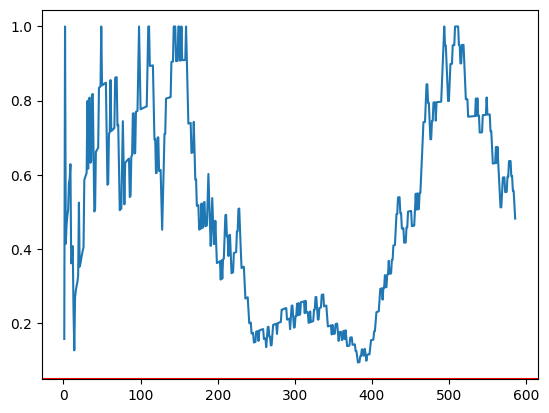

In [ ]:
plt.plot(sizes, pvals)
plt.axhline(y=0.05, color='r')
plt.show()